In [1]:
!pip install keras

# Microsoft stock price prediction with machine learning

Import libraries & Load dataset

In [2]:
import numpy as np #For numerical operations
import pandas as pd #For data loading and manipulation
import matplotlib.pyplot as plt #Visualization
import seaborn as sns #Visualization
from sklearn.preprocessing import MinMaxScaler #Scale data between o and 1
from sklearn.metrics import mean_squared_error,r2_score # Evaluate model performance
from sklearn.model_selection import train_test_split
import tensorflow as tf #Build and train LSTM neural network
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
df=pd.read_csv("/content/MicrosoftStock.csv")
df.head()


,index,date,open,high,low,close,volume,Name
0,390198,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT
1,390199,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT
2,390200,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT
3,390201,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT
4,390202,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB


In [4]:
df.shape

(1259, 8)

In [5]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [6]:
df.isna().sum() #calculate sum of missing values in each column

,0
index,0
date,0
open,0
high,0
low,0
close,0
volume,0
Name,0


In [7]:
df['date']=pd.to_datetime(df['date'])# Convert datatype of date column to datetime format
df.index=df['date'] # Essential for timeseries analysis
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2013-02-08 to 2018-02-07
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   1259 non-null   int64         
 1   date    1259 non-null   datetime64[ns]
 2   open    1259 non-null   float64       
 3   high    1259 non-null   float64       
 4   low     1259 non-null   float64       
 5   close   1259 non-null   float64       
 6   volume  1259 non-null   int64         
 7   Name    1259 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 88.5+ KB


,index,date,open,high,low,close,volume,Name
date,,,,,,,,
2013-02-08,390198,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT
2013-02-11,390199,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT
2013-02-12,390200,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT
2013-02-13,390201,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT
2013-02-14,390202,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT


Shows MSFT closing price changes overtime

Text(0.5, 1.0, 'stock price of microsoft over the years')

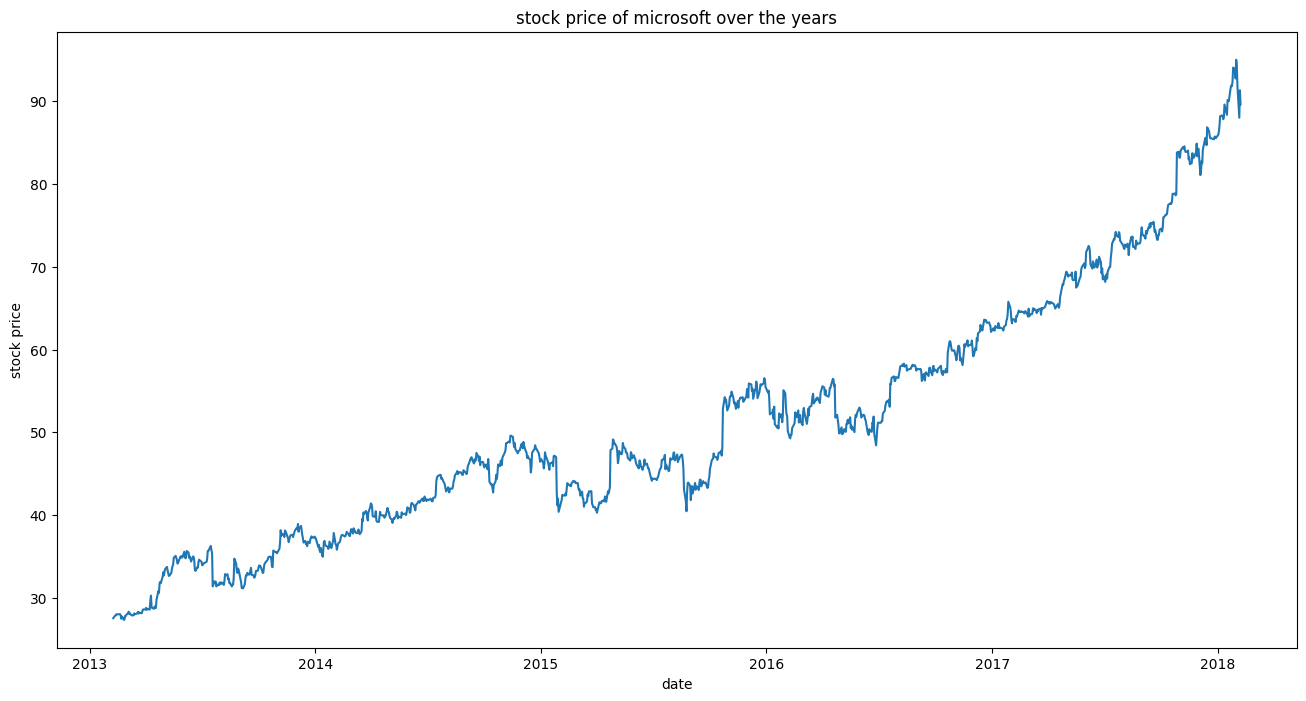

In [8]:
plt.figure(figsize=(16,8))
plt.plot(df['close'],label='close price history')
plt.xlabel('date')
plt.ylabel('stock price')
plt.title('stock price of microsoft over the years')


In [9]:
def plot_graph(figsize,values,column_name):
  plt.figure()
  values.plot(figsize=figsize)
  plt.xlabel("years")
  plt.ylabel(column_name)
  plt.title(f"{column_name} of microsoft data")






In [10]:
df.columns

Index(['index', 'date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')

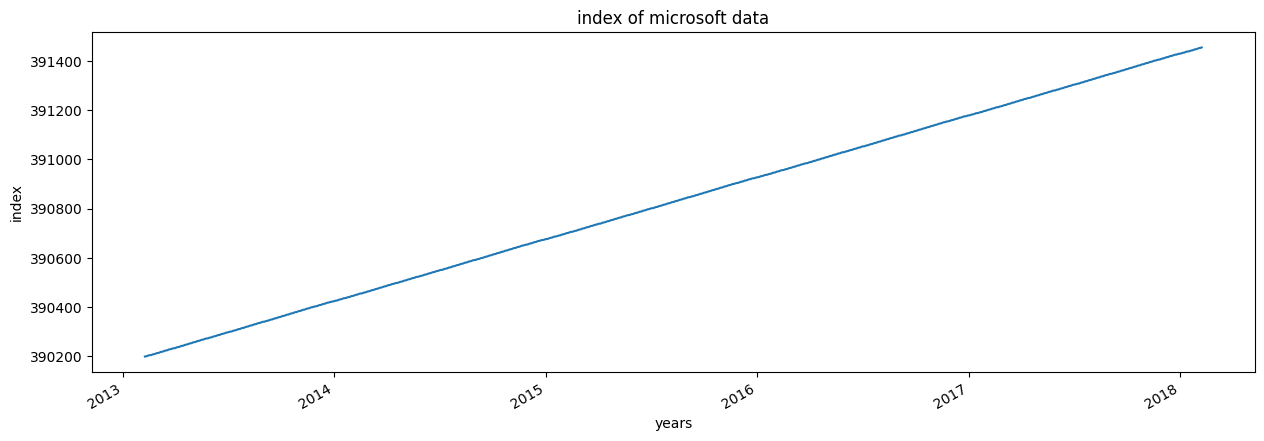

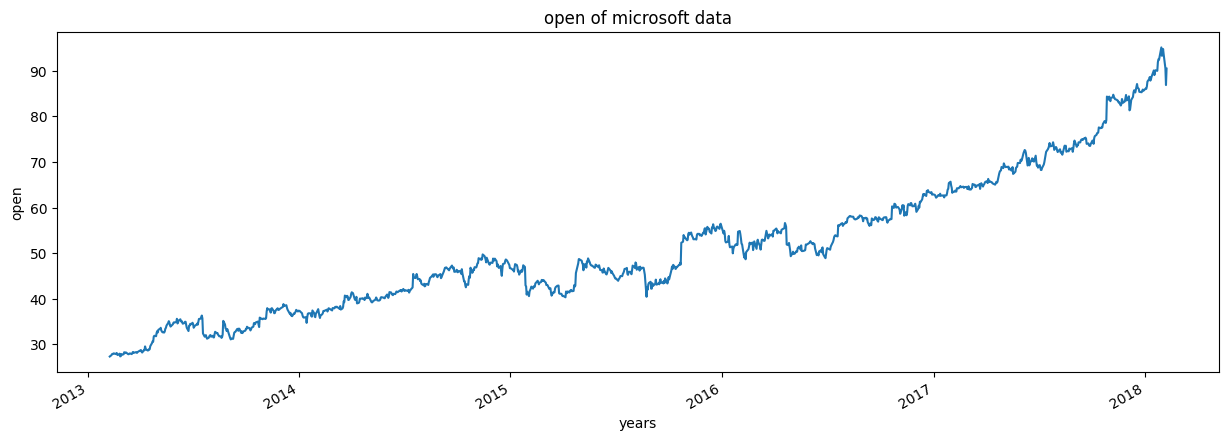

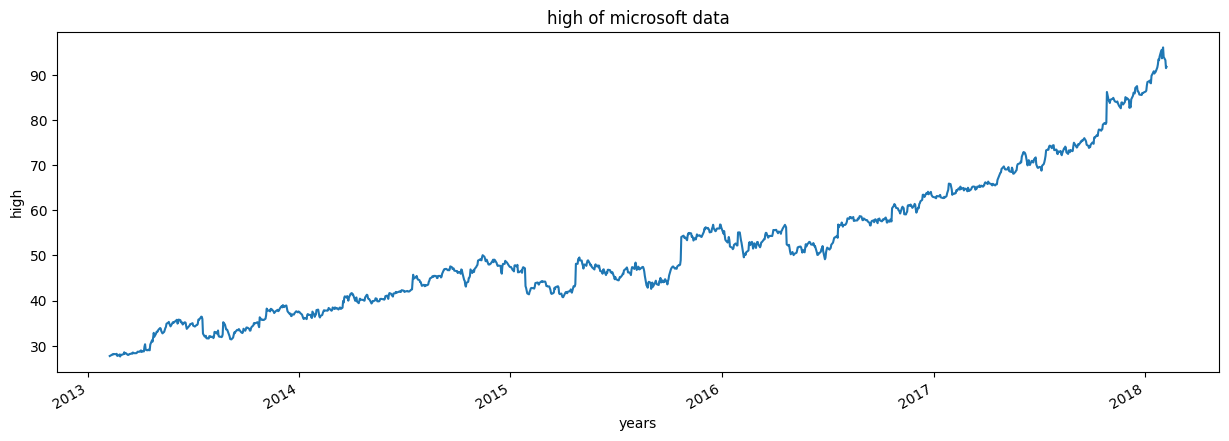

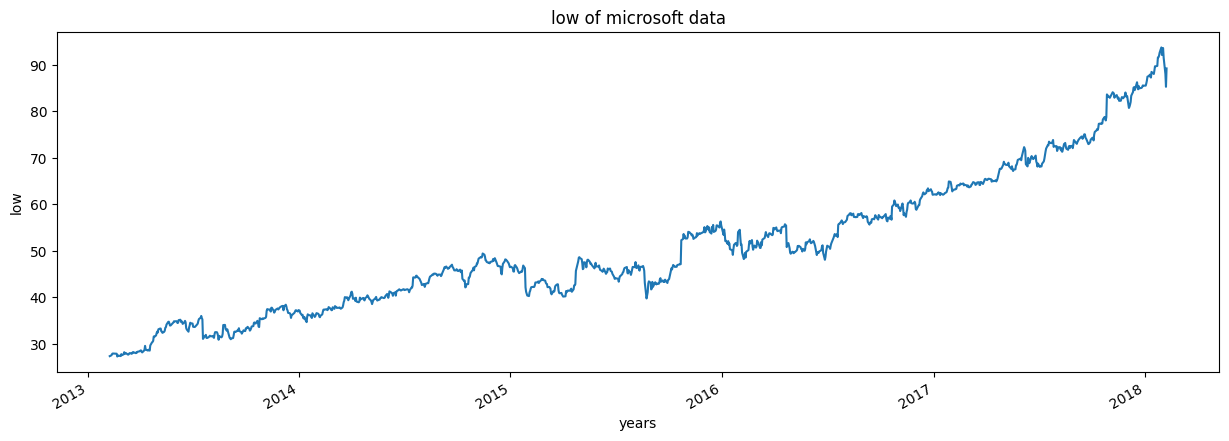

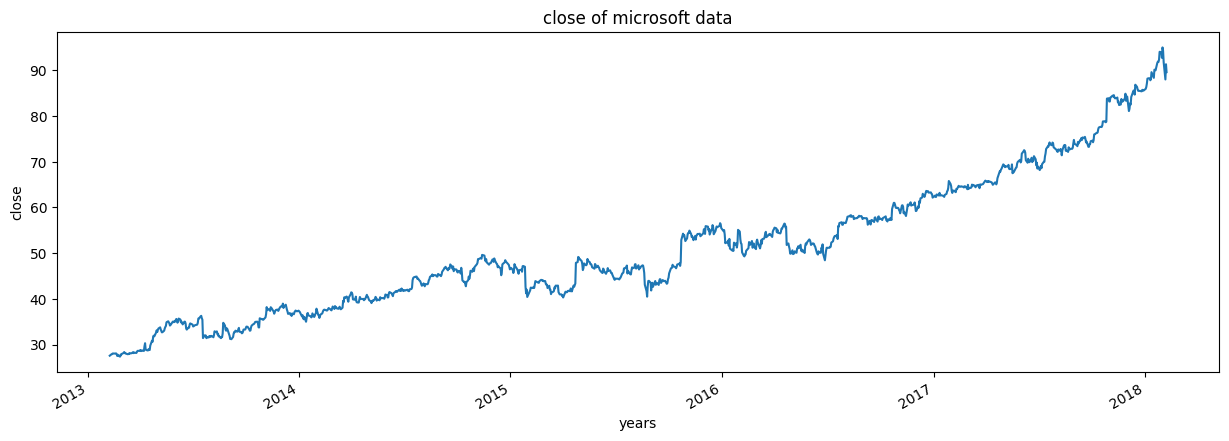

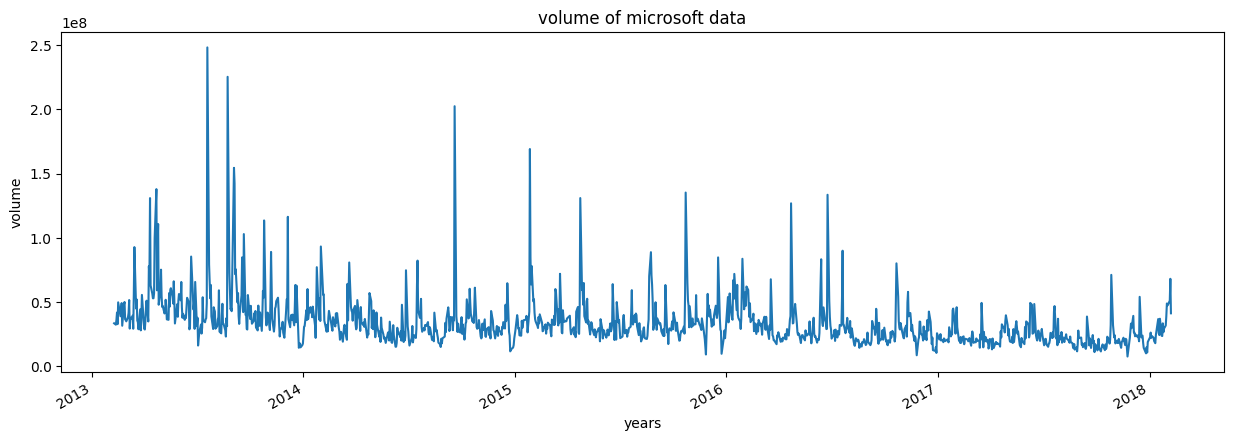

In [11]:
numeric_cols=df.select_dtypes(include='number').columns
for column in numeric_cols:
  plot_graph((15,5),df[column],column)

Shows correlation between numerical features

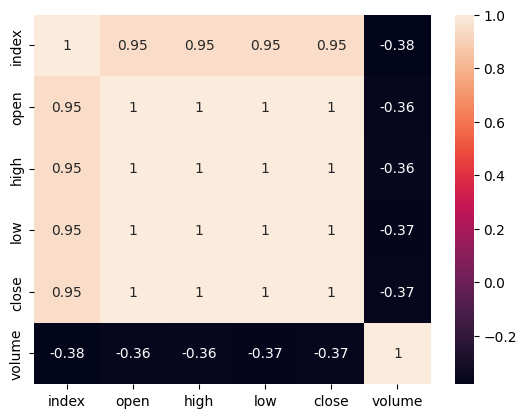

In [12]:
numeric_df=df.select_dtypes(include=['number'])
corr_matrix=numeric_df.corr()
sns.heatmap(corr_matrix,annot=True)
plt.show()

In [13]:
data=df.sort_index(ascending=True,axis=0)
#creating a new dataset(only date and close)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['date','close'])
new_dataset=data[['date','close']].reset_index(drop=True)
new_dataset



,date,close
0,2013-02-08,27.55
1,2013-02-11,27.86
2,2013-02-12,27.88
3,2013-02-13,28.03
4,2013-02-14,28.04
...,...,...
1254,2018-02-01,94.26
1255,2018-02-02,91.78
1256,2018-02-05,88.00
1257,2018-02-06,91.33


In [14]:

new_dataset.index=new_dataset['date']#Set date as index and drop column
new_dataset.drop('date',axis=1,inplace=True)
new_dataset # Final dataset shape:1259 rows & 1 column(close price)



,close
date,
2013-02-08,27.55
2013-02-11,27.86
2013-02-12,27.88
2013-02-13,28.03
2013-02-14,28.04
...,...
2018-02-01,94.26
2018-02-02,91.78
2018-02-05,88.00


split before scailing to avoid data leakage

In [15]:
split_index=int(len(new_dataset)*0.8)
train_data=new_dataset[:split_index]
test_data=new_dataset[split_index :]


In [16]:
scaler=MinMaxScaler(feature_range=(0,1)) #Scales prices between 0 and 1.LSTM performs much better with normalized data
scaled_train_data=scaler.fit_transform(train_data)

create sequence(sliding windows)

In [17]:
# Use previous 60 days to predict the next day.
#x-past 60 days,y-next price
x_train_data,y_train_data=[],[]
for i in range(60,len(scaled_train_data)):
  x_train_data.append(scaled_train_data[i-60:i,0])
  y_train_data.append(scaled_train_data[i,0])

x_train_data=np.array(x_train_data)#Convert to numpy and reshape
y_train_data=np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))#Final shape(samples,time_steps=60,features=1),required for LSTM input

 Building the LSTM model

In [18]:
model=Sequential()
model.add(LSTM(units=128,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
model.add(Dropout(.2))#Prevent overfitting
model.add(LSTM(units=64))
model.add(Dropout(.2))
model.add(Dense(1))
print(model.summary())


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
from keras.metrics import RootMeanSquaredError
model.compile(optimizer='adam',loss='mean_squared_error',metrics=[RootMeanSquaredError])#adam for fast convergence
model.fit(x_train_data,y_train_data,epochs=4,batch_size=16,verbose=2)
#epochs=4 means model sees the data 4 times
#batch size =16 means updates weights after every 16 samples
#verbose=2 means print loss and RMSE per epoch

Epoch 1/4
60/60 - 13s - 223ms/step - loss: 0.0188 - root_mean_squared_error: 0.1369
Epoch 2/4
60/60 - 2s - 39ms/step - loss: 0.0031 - root_mean_squared_error: 0.0557
Epoch 3/4
60/60 - 0s - 8ms/step - loss: 0.0033 - root_mean_squared_error: 0.0573
Epoch 4/4
60/60 - 0s - 8ms/step - loss: 0.0029 - root_mean_squared_error: 0.0540


In [20]:
#Preparing input data for prediction
inputs_data=new_dataset[len(new_dataset)-len(test_data)-60 :].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [21]:
#creating test sequences(sliding window)
x_test=[]
for i in range(60,inputs_data.shape[0]):
  x_test.append(inputs_data[i-60:i,0])
x_test=np.array(x_test)
#reshaping for LSTM input.LSTM expects input shape:(samples,timesteps,features)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
closing_price=model.predict(x_test)#Predict scaled closing price
closing_price=scaler.inverse_transform(closing_price)#convets predictions back to original price sale




8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Splitting dataset

/tmp/ipython-input-92222230.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predictions']=closing_price#Stores predicted price intest data


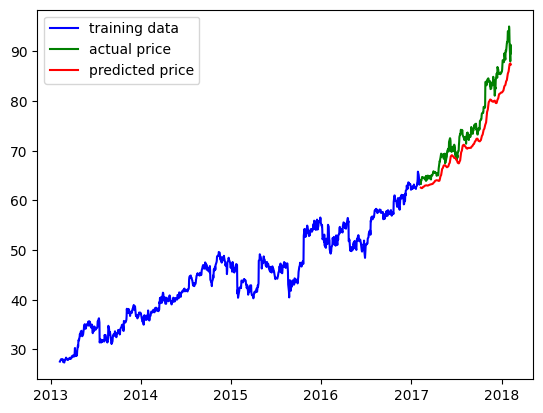

In [22]:
split_index=int(len(new_dataset)*0.8)
train_data=new_dataset[:split_index]
test_data=new_dataset[split_index :]
test_data['predictions']=closing_price#Stores predicted price in test data
#Plotting
plt.plot(train_data["close"],label="training data",color='blue')
plt.plot(test_data["close"],label="actual price",color='green')
plt.plot(test_data["predictions"],label="predicted price",color='red')

plt.legend()


Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
x=df[['open','high','low','volume']]
y=df[['close']]



In [24]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42)
model_1=LinearRegression()
model_1.fit(x_train,y_train)
predictions=model_1.predict(x_test)
r2=r2_score(y_test,predictions)
print(f"r squared:{r2}")

r squared:0.9997123561895437


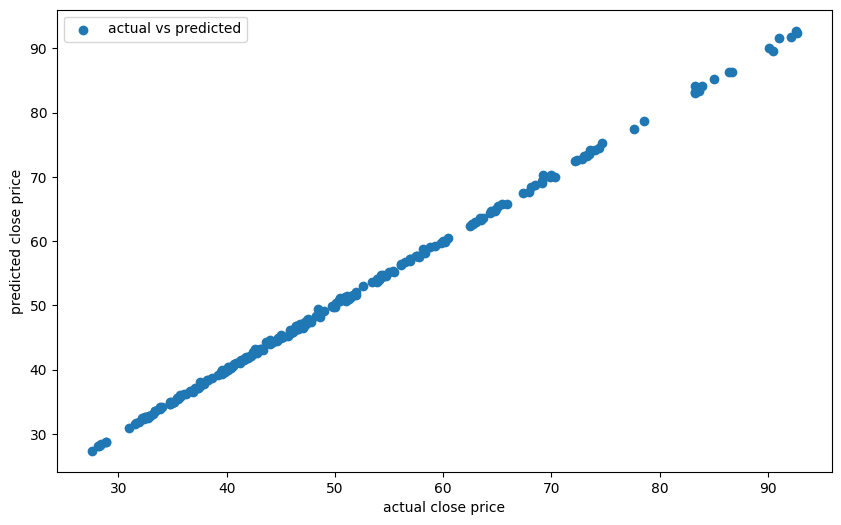

In [25]:
plt.figure(figsize=(10,6))
plt.scatter(predictions,y_test,label='actual vs predicted')
plt.xlabel('actual close price')
plt.ylabel("predicted close price")
plt.legend()
plt.show()


Random Forest

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
x=df[['open','high','low','volume']]
y=df[['close']]
y

,close
date,
2013-02-08,27.55
2013-02-11,27.86
2013-02-12,27.88
2013-02-13,28.03
2013-02-14,28.04
...,...
2018-02-01,94.26
2018-02-02,91.78
2018-02-05,88.00


In [27]:
train_size=int(len(x)*.8)
x_train,x_test=x[: train_size],x[train_size :]
y_train,y_test=y[: train_size],y[train_size :]
rf_model=RandomForestRegressor(n_estimators=100,random_state=42,min_samples_leaf=1)
rf_model.fit(x_train,y_train)
predictions=rf_model.predict(x_test)
mse=mean_squared_error(y_test,predictions)
rmse=np.sqrt(mse)
mae=mean_absolute_error(y_test,predictions)
print(f"mse:{mse}")
print(f"rmse:{rmse}")
print(f"mae:{mae}")



/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


mse:159.3659044033338
rmse:12.624020928505061
mae:9.665895238095258


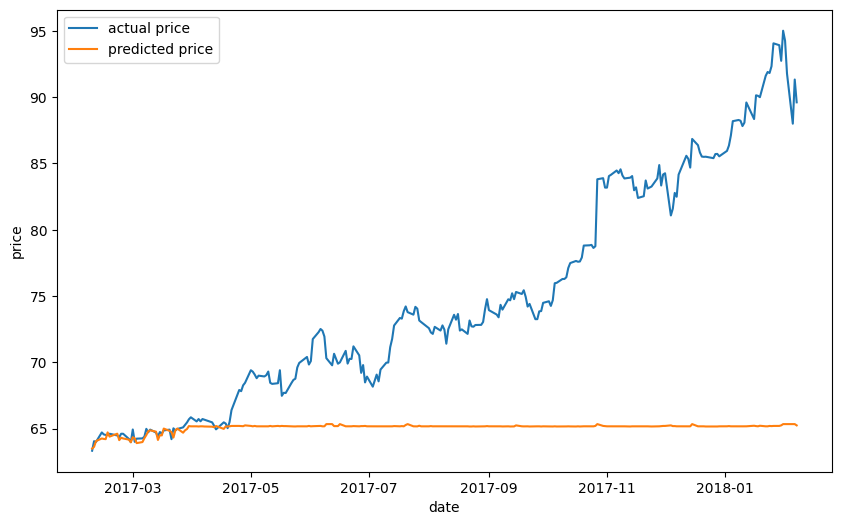

In [28]:
plt.figure(figsize=(10,6))
plt.plot(y_test.index,y_test,label="actual price")
plt.plot(y_test.index,predictions,label="predicted price")
plt.xlabel('date')
plt.ylabel("price")
plt.legend()
plt.show()


XGboost

In [29]:
from xgboost import XGBRegressor
x=df[['open','high','low','volume']]
y=df[['close']]
x


,open,high,low,volume
date,,,,
2013-02-08,27.35,27.710,27.3100,33318306
2013-02-11,27.65,27.920,27.5000,32247549
2013-02-12,27.88,28.000,27.7500,35990829
2013-02-13,27.93,28.110,27.8800,41715530
2013-02-14,27.92,28.060,27.8700,32663174
...,...,...,...,...
2018-02-01,94.79,96.070,93.5813,47227882
2018-02-02,93.64,93.970,91.5000,47867753
2018-02-05,90.56,93.240,88.0000,51031465


In [30]:
train_size=int(len(x)*.8)
x_train,x_test=x[: train_size],x[train_size :]
y_train,y_test=y[: train_size],y[train_size :]
xgb_model=XGBRegressor(n_estimators=100,random_state=42,learning_rate=.1)
xgb_model.fit(x_train,y_train)
predictions=xgb_model.predict(x_test)
mae=mean_absolute_error(y_test,predictions)
print(f"mae:{mae}")

mae:10.176939010620117


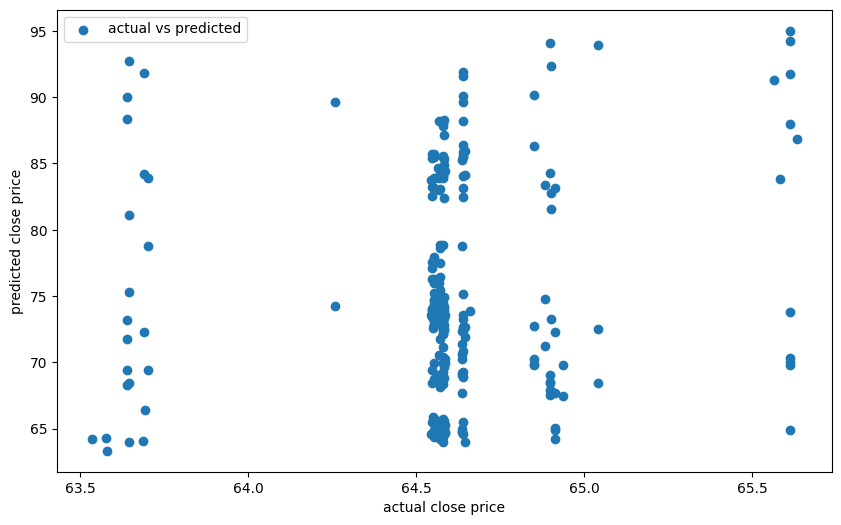

In [31]:
plt.figure(figsize=(10,6))
plt.scatter(predictions,y_test,label='actual vs predicted')
plt.xlabel('actual close price')
plt.ylabel("predicted close price")
plt.legend()
plt.show()

In [32]:
!pip install yfinance

Microsoft stock price prediction of next 30 days real time data

In [33]:

import yfinance as yf#to download microsoft stock data
from datetime import date,timedelta
ticker_symbol="MSFT"
start_date=date.today()-timedelta(5*365)#download last 5 years of data
end_date=date.today()
df=yf.download(ticker_symbol,start=start_date,end=end_date)
df


/tmp/ipython-input-545809180.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download(ticker_symbol,start=start_date,end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2021-01-11,208.690277,210.052822,207.961018,209.630622,23031300
2021-01-12,206.233871,208.316086,204.689027,207.740356,23249300
2021-01-13,207.586838,207.989843,205.274343,205.360713,20087100
2021-01-14,204.401184,208.661543,204.132514,207.174254,29480800
2021-01-15,204.046097,205.830841,203.451187,204.880906,31746500
...,...,...,...,...,...
2025-12-31,483.619995,488.140015,483.299988,487.839996,15601600
2026-01-02,472.940002,484.660004,470.160004,484.390015,25571600


In [34]:
data=df['Close'].values.reshape(-1,1)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(data)
scaled_data


array([[0.01378049],
       [0.0064917 ],
       [0.0105063 ],
       ...,
       [0.79761102],
       [0.81440573],
       [0.82912331]])

function to createLSTM sequences

In [35]:
def create_sequences (dataset,time_step=60):
  x,y=[],[]
  for i in range(60,len(dataset)):
    x.append(dataset[i-60:i,0])
    y.append(dataset[i,0])
  return np.array(x),np.array(y)#Convert list to numpy arrays

time_step=60
x,y=create_sequences(scaled_data,time_step)
x,y



(array([[0.01378049, 0.0064917 , 0.0105063 , ..., 0.10532858, 0.10187545,
         0.10769728],
        [0.0064917 , 0.0105063 , 0.00105364, ..., 0.10187545, 0.10769728,
         0.11725738],
        [0.0105063 , 0.00105364, 0.        , ..., 0.10769728, 0.11725738,
         0.12467711],
        ...,
        [0.94899914, 0.94174308, 0.90786092, ..., 0.84102205, 0.82956838,
         0.79787807],
        [0.94174308, 0.90786092, 0.91701253, ..., 0.82956838, 0.79787807,
         0.79761102],
        [0.90786092, 0.91701253, 0.91559102, ..., 0.79787807, 0.79761102,
         0.81440573]]),
 array([0.11725738, 0.12467711, 0.12484826, ..., 0.79761102, 0.81440573,
        0.82912331]))

In [36]:
x=x.reshape(x.shape[0],x.shape[1],1)#convets input data into 3D format,required by LSTM
x

array([[[0.01378049],
        [0.0064917 ],
        [0.0105063 ],
        ...,
        [0.10532858],
        [0.10187545],
        [0.10769728]],

       [[0.0064917 ],
        [0.0105063 ],
        [0.00105364],
        ...,
        [0.10187545],
        [0.10769728],
        [0.11725738]],

       [[0.0105063 ],
        [0.00105364],
        [0.        ],
        ...,
        [0.10769728],
        [0.11725738],
        [0.12467711]],

       ...,

       [[0.94899914],
        [0.94174308],
        [0.90786092],
        ...,
        [0.84102205],
        [0.82956838],
        [0.79787807]],

       [[0.94174308],
        [0.90786092],
        [0.91701253],
        ...,
        [0.82956838],
        [0.79787807],
        [0.79761102]],

       [[0.90786092],
        [0.91701253],
        [0.91559102],
        ...,
        [0.79787807],
        [0.79761102],
        [0.81440573]]])

In [37]:
model=Sequential()
model.add(LSTM(units=128,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
model.add(Dropout(.2))#Randomly disable 20% of neurons,prevent overfitting
model.add(LSTM(units=64))
model.add(Dropout(.2))
model.add(Dense(1))
print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [38]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=[RootMeanSquaredError])
model.fit(x,y,epochs=4,batch_size=16,verbose=2)

Epoch 1/4
75/75 - 3s - 42ms/step - loss: 0.0138 - root_mean_squared_error: 0.1175
Epoch 2/4
75/75 - 2s - 20ms/step - loss: 0.0030 - root_mean_squared_error: 0.0549
Epoch 3/4
75/75 - 2s - 30ms/step - loss: 0.0030 - root_mean_squared_error: 0.0544
Epoch 4/4
75/75 - 2s - 25ms/step - loss: 0.0030 - root_mean_squared_error: 0.0550


In [39]:
last_60_days=scaled_data[-time_step:]#Extract last 60 days
predictions_30_days=[]#prepare for 30 day prediction
current_input=last_60_days.reshape(1,time_step,1)
current_input

array([[[0.91701253],
        [0.91559102],
        [0.91517629],
        [0.90978599],
        [0.91562072],
        [0.92512758],
        [0.92770437],
        [0.93623416],
        [0.93629338],
        [0.94532665],
        [0.96875394],
        [1.        ],
        [0.99845986],
        [0.95169437],
        [0.92814863],
        [0.92583861],
        [0.917842  ],
        [0.89660637],
        [0.86681153],
        [0.86598224],
        [0.89317077],
        [0.90110815],
        [0.9083941 ],
        [0.88514455],
        [0.90555071],
        [0.89758372],
        [0.85700829],
        [0.83725357],
        [0.81416829],
        [0.79544489],
        [0.80102336],
        [0.80989543],
        [0.83514684],
        [0.85446373],
        [0.83882622],
        [0.84849951],
        [0.81209127],
        [0.8213194 ],
        [0.82820347],
        [0.85152608],
        [0.85449334],
        [0.81455405],
        [0.82912331],
        [0.81446504],
        [0.80345653],
        [0

In [40]:
import numpy as np
#predict next 30 days
#loop runs 30 times,each iteration predicts 1 future day
for i in range(30):
  next_day_prediction_scaled=model.predict(current_input,verbose=0)
  predictions_30_days.append(next_day_prediction_scaled[0,0])# save prediction in list
  current_input=np.append(current_input[:,1:,:],next_day_prediction_scaled.reshape(1,1,1),axis=1)
#Drops oldest day ,add new predicted day,maintains 60 day sliding window
predictions_30_days=scaler.inverse_transform(np.array(predictions_30_days).reshape(-1,1))
prediction_dates=[end_date+timedelta(days=i) for i in range(1,31)]# create future dates
for date_str,price in zip(prediction_dates,predictions_30_days):
  print(f"date:{date_str},predicted_close_price:{price[0]:.2f}")



date:2026-01-09,predicted_close_price:479.60
date:2026-01-10,predicted_close_price:478.99
date:2026-01-11,predicted_close_price:478.43
date:2026-01-12,predicted_close_price:477.92
date:2026-01-13,predicted_close_price:477.45
date:2026-01-14,predicted_close_price:476.99
date:2026-01-15,predicted_close_price:476.55
date:2026-01-16,predicted_close_price:476.12
date:2026-01-17,predicted_close_price:475.70
date:2026-01-18,predicted_close_price:475.28
date:2026-01-19,predicted_close_price:474.87
date:2026-01-20,predicted_close_price:474.46
date:2026-01-21,predicted_close_price:474.05
date:2026-01-22,predicted_close_price:473.64
date:2026-01-23,predicted_close_price:473.24
date:2026-01-24,predicted_close_price:472.84
date:2026-01-25,predicted_close_price:472.44
date:2026-01-26,predicted_close_price:472.05
date:2026-01-27,predicted_close_price:471.66
date:2026-01-28,predicted_close_price:471.27
date:2026-01-29,predicted_close_price:470.88
date:2026-01-30,predicted_close_price:470.49
date:2026-

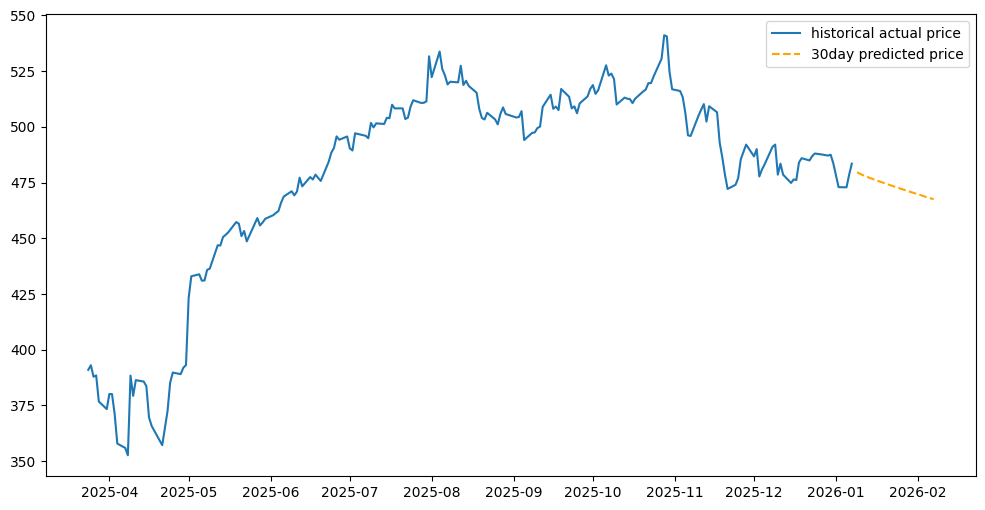

In [41]:
#plot historical and future prices
plt.figure(figsize=(12,6))
plt.plot(df.index[-200 :],df['Close'].tail(200),label='historical actual price')
plt.plot(prediction_dates,predictions_30_days,color='orange',linestyle='--',label='30day predicted price')
plt.legend()
plt.show()
